In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from os.path import join
import pickle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold, ShuffleSplit

In [2]:
model = pickle.load(open('model.pickl', 'rb'))
model

/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pa

Pipeline(memory=None,
     steps=[('cluster', NDGrid(max=1.2, min=-1.2, n_bins_per_feature=200)), ('msm', MaximumLikelihoodMSM(connectivity='largest', count_mode='sliding',
           dt_traj='1 step', lag=25, maxerr=1e-08, maxiter=1000000,
           mincount_connectivity='1/n', reversible=True, score_k=10,
           score_method='VAMP2', sparse=False, statdist_constraint=None))])

In [3]:
paths = ['data/000.5pc/quad_well_{:02d}.npy'.format(x) for x in range(100)]
# paths
X = [np.load(x) for x in paths]

len(X)
X[0].shape

(422, 1)

In [4]:
model.set_params(cluster__n_bins_per_feature=100)
model.set_params(msm__score_k=4)
model

Pipeline(memory=None,
     steps=[('cluster', NDGrid(max=1.2, min=-1.2, n_bins_per_feature=100)), ('msm', MaximumLikelihoodMSM(connectivity='largest', count_mode='sliding',
           dt_traj='1 step', lag=25, maxerr=1e-08, maxiter=1000000,
           mincount_connectivity='1/n', reversible=True, score_k=4,
           score_method='VAMP2', sparse=False, statdist_constraint=None))])

In [79]:
data = {'score_method':[],'n_evaluations':[], 'cv_method': [], 'n_repeats': [], 'MCV': [],'MedCV': [], 'MCV_err': []}
score_methods = ['vamp1', 'vamp2','vampe']
cv_methods = {'Repeated2Fold': RepeatedKFold(n_splits=2), 'Repeated5Fold': RepeatedKFold(n_splits=5), 
              'Repeated10Fold': RepeatedKFold(n_splits=10),'ShuffleSplit': ShuffleSplit(test_size=0.5)
              }
n_repeats = [5,10,15,20]

In [80]:

for score_method in score_methods:
    model.set_params(msm__score_method=score_method)
    model.set_params(msm__score_k=4)    
    for k, v in cv_methods.items():
        for n in n_repeats:
            rs = np.random.randint(1,10000)
            if k=='ShuffleSplit':
                v.n_splits=n
            else:
                v.n_repeats=n
            v.random_state=rs
            print(k, v.random_state)
            
            scores = cross_val_score(model, X, cv=v)
            data['n_evaluations'].append(v.get_n_splits())
            data['score_method'].append(score_method)
            data['cv_method'].append(k)
            data['n_repeats'].append(n)
            data['MCV'].append(np.mean(scores))
            data['MedCV'].append(np.median(scores))
            data['MCV_err'].append(np.std(scores))



Repeated5Fold 3221
Repeated5Fold 3348
Repeated5Fold 2331
Repeated5Fold 9285
ShuffleSplit 5967
ShuffleSplit 956
ShuffleSplit 8005
ShuffleSplit 5111
Repeated10Fold 3501
Repeated10Fold 1921
Repeated10Fold 4331
Repeated10Fold 3622
Repeated2Fold 6745
Repeated2Fold 1494
Repeated2Fold 3682
Repeated2Fold 7460
Repeated5Fold 7001
Repeated5Fold 6118
Repeated5Fold 2759
Repeated5Fold 4969
ShuffleSplit 5870
ShuffleSplit 6762
ShuffleSplit 7818
ShuffleSplit 4148
Repeated10Fold 7924
Repeated10Fold 8470
Repeated10Fold 2110
Repeated10Fold 111
Repeated2Fold 2328
Repeated2Fold 7960
Repeated2Fold 5759
Repeated2Fold 4431
Repeated5Fold 6502
Repeated5Fold 5006
Repeated5Fold 737
Repeated5Fold 318
ShuffleSplit 3200
ShuffleSplit 9568
ShuffleSplit 1342
ShuffleSplit 5479
Repeated10Fold 5764
Repeated10Fold 5115
Repeated10Fold 429
Repeated10Fold 6219
Repeated2Fold 2806
Repeated2Fold 2130
Repeated2Fold 1518
Repeated2Fold 4397


In [84]:
import pickle 
pickle.dump(data, open('CV_technique_data.pickl', 'wb'))
df = pd.DataFrame(data)
df.head()

MCV   MCV_err     MedCV      cv_method  n_evaluations  n_repeats  \
0  3.462146  0.053452  3.454219  Repeated5Fold             25          5   
1  3.457280  0.060175  3.463594  Repeated5Fold             50         10   
2  3.457885  0.069748  3.472626  Repeated5Fold             75         15   
3  3.457864  0.058554  3.457553  Repeated5Fold            100         20   
4  3.472944  0.031125  3.465170   ShuffleSplit              5          5   

  score_method  
0        vamp1  
1        vamp1  
2        vamp1  
3        vamp1  
4        vamp1

In [140]:
exact_values= pd.read_pickle('vamp_exact_values.pickl')
k = 4
exact_values.head()

k     m method     score
486  2  1000  vamp1  1.970829
487  2  1000  vamp2  1.942510
488  2  1000  vampe  1.942510
489  3  1000  vamp1  2.790256
490  3  1000  vamp2  2.613970

In [144]:
df.head()
score_methods


492    3.468035
Name: score, dtype: float64

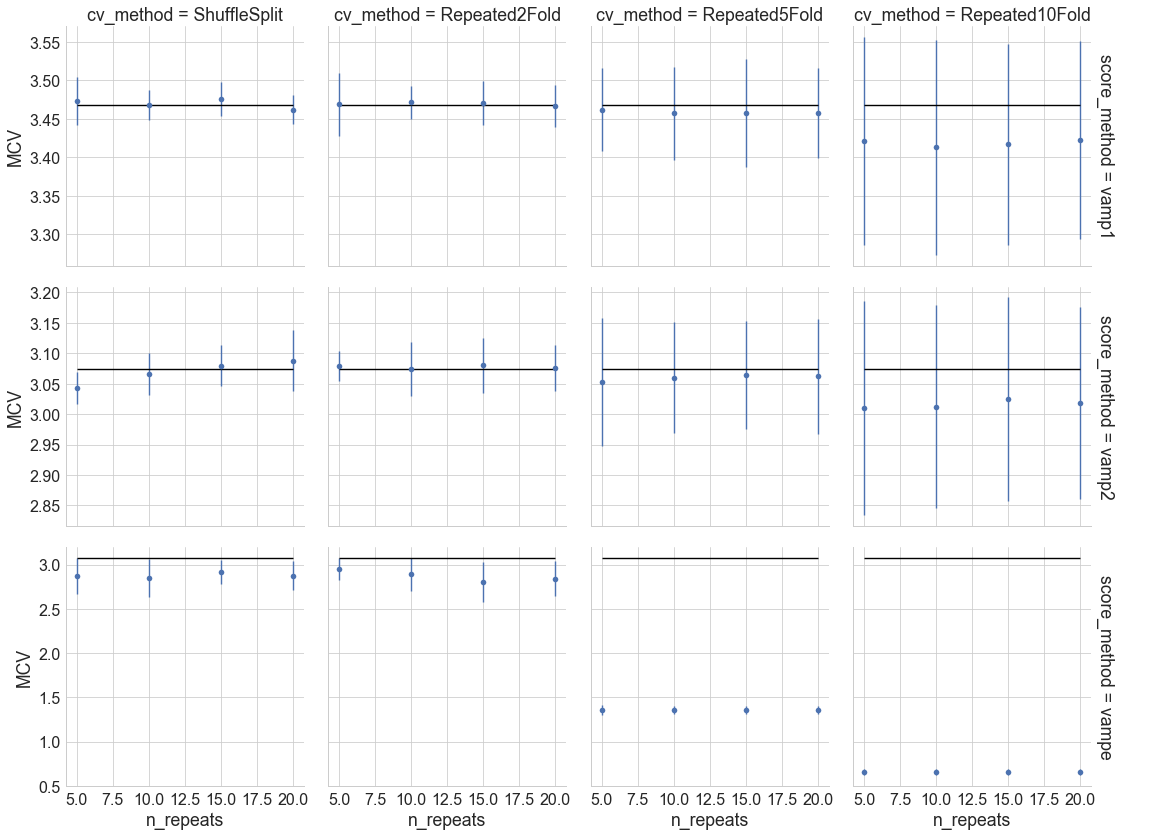

In [172]:
methods_ord=['ShuffleSplit', 'Repeated2Fold', 'Repeated5Fold', 'Repeated10Fold']
with sns.plotting_context('paper', font_scale=2):
    sns.set_style('whitegrid')
    g = sns.FacetGrid(data=df, row='score_method', col='cv_method',row_order=score_methods, sharey='row', 
                      col_order=methods_ord, margin_titles=True,size=4)
    g.map(plt.errorbar, 'n_repeats', 'MCV', 'MCV_err', ls=' ', marker='o').add_legend()
#     g.set_titles("{row_name} | {col_name}")
#     g.set(xlim=(0,50))
    for i in range(g.axes.shape[0]):
        for j in range(g.axes.shape[1]):
            ax = g.axes[i][j]
            vamp_exact = exact_values.loc[(exact_values['k']==k) & (exact_values['method']==score_methods[i])
                                          , 'score']
            ax.hlines(vamp_exact, df['n_repeats'].min(), df['n_repeats'].max())

    plt.savefig('figures/mcv_n_repeats.png', transparent=True)

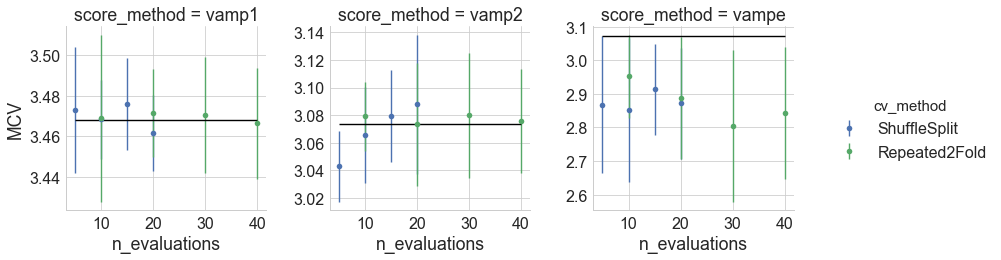

In [179]:
methods_ord=['ShuffleSplit', 'Repeated2Fold']
sample = df.loc[df['cv_method'].isin(methods_ord), :]
with sns.plotting_context('paper', font_scale=2):
    sns.set_style('whitegrid')
    g = sns.FacetGrid(data=sample,  col='score_method', hue='cv_method',col_order=score_methods, sharey=False, 
                      hue_order=methods_ord, margin_titles=True,size=4)
    g.map(plt.errorbar, 'n_evaluations', 'MCV', 'MCV_err', ls=' ', marker='o').add_legend()
#     g.set_titles("{row_name} | {col_name}")
#     g.set(xlim=(0,50))
    for i in range(g.axes.shape[0]):
        for j in range(g.axes.shape[1]):
            ax = g.axes[i][j]
            vamp_exact = exact_values.loc[(exact_values['k']==k) & (exact_values['method']==score_methods[j])
                                          , 'score']
            ax.hlines(vamp_exact, sample['n_evaluations'].min(), sample['n_evaluations'].max())

    plt.savefig('figures/mcv_n_evaluations.png', transparent=True)

In [103]:
data_ss = {'score_method':[],'n_evaluations':[], 'cv_method': [], 'n_repeats': [], 'scores':[]}
score_methods = ['vamp1', 'vamp2','vampe']
cv_methods = {'ShuffleSplit': ShuffleSplit(test_size=0.5)
              }
n_evaluations = np.logspace(1,2,5).astype(int)
n_evaluations


array([ 10,  17,  31,  56, 100])

In [104]:

for score_method in score_methods:
    model.set_params(msm__score_method=score_method)
    model.set_params(msm__score_k=4)    
    for k, v in cv_methods.items():
        for n in n_evaluations:
            rs = np.random.randint(1,10000)
            if k=='ShuffleSplit':
                v.n_splits=n
            else:
                v.n_repeats=n
            v.random_state=rs
            print(k, v.random_state)
            
            scores = cross_val_score(model, X, cv=v)
            data_ss['n_evaluations'].append(v.get_n_splits())
            data_ss['score_method'].append(score_method)
            data_ss['cv_method'].append(k)
            data_ss['n_repeats'].append(n)
            data_ss['scores'].append(scores)
#             data['MCV'].append(np.mean(scores))
#             data['MedCV'].append(np.median(scores))
#             data['MCV_err'].append(np.std(scores))




ShuffleSplit 8698
ShuffleSplit 6685
ShuffleSplit 6607
ShuffleSplit 6166
ShuffleSplit 9325
ShuffleSplit 6957
ShuffleSplit 5297
ShuffleSplit 1804
ShuffleSplit 9160
ShuffleSplit 8340
ShuffleSplit 9990
ShuffleSplit 3966
ShuffleSplit 935
ShuffleSplit 3965
ShuffleSplit 6675


In [112]:
df_ss = pd.DataFrame(data_ss)

In [113]:
df_ss.head()

cv_method  n_evaluations  n_repeats score_method  \
0  ShuffleSplit             10         10        vamp1   
1  ShuffleSplit             17         17        vamp1   
2  ShuffleSplit             31         31        vamp1   
3  ShuffleSplit             56         56        vamp1   
4  ShuffleSplit            100        100        vamp1   

                                              scores  
0  [3.47575772442, 3.44816741679, 3.48791858951, ...  
1  [3.47120749564, 3.49986026579, 3.49695707404, ...  
2  [3.45878344189, 3.4928757058, 3.51315835104, 3...  
3  [3.45332215067, 3.4717546105, 3.45676311172, 3...  
4  [3.48211605187, 3.47299959927, 3.40830688927, ...

In [118]:
df_expanded = []
for col in ['scores']:    
    s = df_ss.apply(lambda x: pd.Series(x[col]),axis=1).stack().reset_index(level=1, drop=True)
    s.name=col
    df_expanded.append(pd.DataFrame(s))
    df_ss.drop(labels=col, axis=1, inplace=True)
    
df_expanded = pd.concat(df_expanded, axis=1)

In [121]:
df_ss_exp = df_ss.merge(right=df_expanded, how='inner', right_index=True, left_index=True, sort=True)

df_ss_exp.head()

cv_method  n_evaluations  n_repeats score_method    scores
0  ShuffleSplit             10         10        vamp1  3.475758
0  ShuffleSplit             10         10        vamp1  3.448167
0  ShuffleSplit             10         10        vamp1  3.487919
0  ShuffleSplit             10         10        vamp1  3.491570
0  ShuffleSplit             10         10        vamp1  3.512396

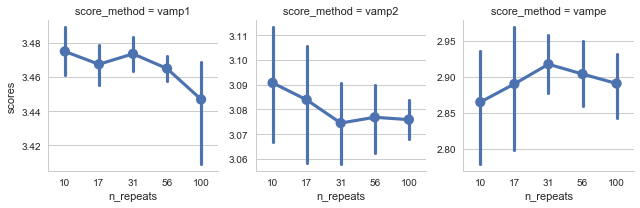

In [127]:
g = sns.FacetGrid(col='score_method', data=df_ss_exp, sharey=False)
g.map(sns.pointplot,'n_repeats', 'scores')

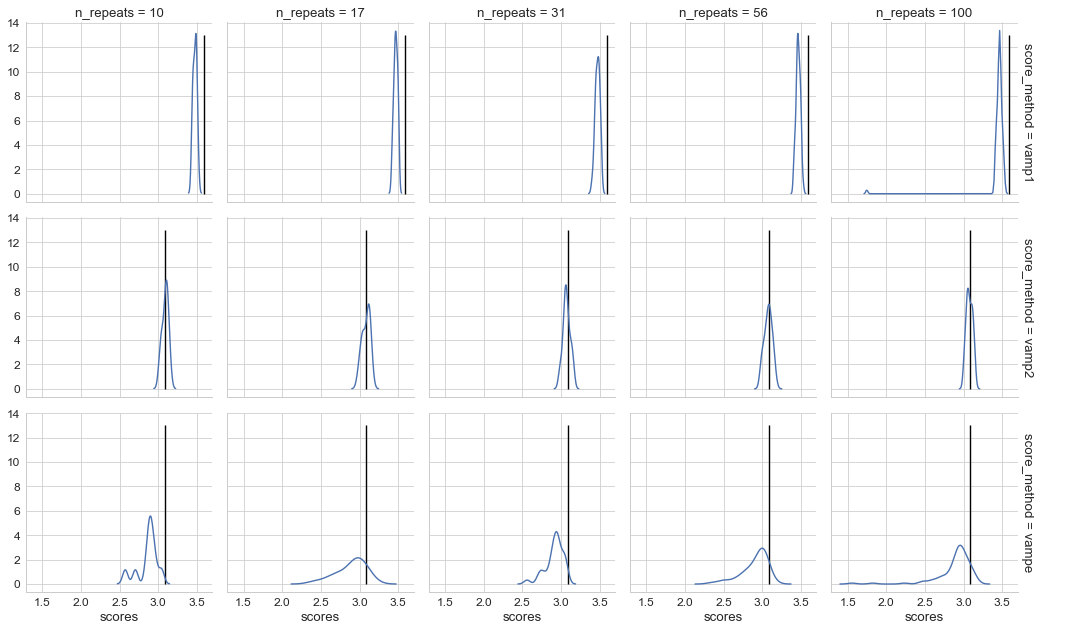

In [185]:
with sns.plotting_context('paper', font_scale=1.5):
    g = sns.FacetGrid(row='score_method', col='n_repeats', data=df_ss_exp, sharey=True, row_order=score_methods, 
                     palette=sns.light_palette('navy'), margin_titles=True)
    g.map(sns.distplot,'scores', hist=False).add_legend()
    for i in range(g.axes.shape[0]):
        for j in range(g.axes.shape[1]):
            ax = g.axes[i][j]
            vamp_exact = exact_values.loc[(exact_values['k']==5) & 
                                          (exact_values['method']==score_methods[i])
                                          , 'score']
            ax.vlines(vamp_exact, 0, 13)
    plt.savefig('figures/shuffle_split_dist_vs_n_repeats.png', transparent=True)


## Test with X_split data

In [5]:
X = np.load('data/000.5pc-split/X-25.npy')

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold, ShuffleSplit


model = pickle.load(open('model_lag1.pickl', 'rb'))
model


Pipeline(memory=None,
     steps=[('reshape', DtrajReshape()), ('cluster', NDGrid(max=1.2, min=-1.2, n_bins_per_feature=200)), ('msm', MaximumLikelihoodMSM(connectivity='largest', count_mode='sliding',
           dt_traj='1 step', lag=1, maxerr=1e-08, maxiter=1000000,
           mincount_connectivity='1/n', reversible=True, score_k=10,
           score_method='vamp1', sparse=False, statdist_constraint=None))])

In [10]:
model.set_params(cluster__n_bins_per_feature=100)
model.set_params(msm__score_k=4)

Pipeline(memory=None,
     steps=[('reshape', DtrajReshape()), ('cluster', NDGrid(max=1.2, min=-1.2, n_bins_per_feature=100)), ('msm', MaximumLikelihoodMSM(connectivity='largest', count_mode='sliding',
           dt_traj='1 step', lag=1, maxerr=1e-08, maxiter=1000000,
           mincount_connectivity='1/n', reversible=True, score_k=4,
           score_method='vamp1', sparse=False, statdist_constraint=None))])

In [18]:
data_split = {'score_method':[],'n_evaluations':[], 'cv_method': [], 'n_repeats': [], 'scores':[]}
score_methods = ['vamp1', 'vamp2','vampe']
cv_methods = {'ShuffleSplit': ShuffleSplit(test_size=0.5)
              }
# n_repeats = np.logspace(np.log10(5),2,5).astype(int)
n_repeats = [50]

In [19]:
for score_method in score_methods:
    model.set_params(msm__score_method=score_method)
    model.set_params(msm__score_k=4)    
    for k, v in cv_methods.items():
        for n in n_repeats:
            rs = np.random.randint(1,10000)
            if k=='ShuffleSplit':
                v.n_splits=n
            else:
                v.n_repeats=n
            v.random_state=rs
            print(score_method, k, n)
            scores = cross_val_score(model, X, cv=v)
            data_split['n_evaluations'].append(v.get_n_splits())
            data_split['score_method'].append(score_method)
            data_split['cv_method'].append(k)
            data_split['n_repeats'].append(n)
            data_split['scores'].append(scores)
#             data_split['MCV'].append(np.mean(scores))
#             data_split['MedCV'].append(np.median(scores))
#             data_split['MCV_err'].append(np.std(scores))

vamp1 ShuffleSplit 50
vamp2 ShuffleSplit 50
vampe ShuffleSplit 50


In [20]:
df_split = pd.DataFrame(data_split)

In [23]:
df_split.drop(labels=['n_evaluations', 'n_repeats'], inplace=True, axis=1)


In [28]:
df_split

cv_method score_method  \
0  ShuffleSplit        vamp1   
1  ShuffleSplit        vamp2   
2  ShuffleSplit        vampe   

                                              scores  
0  [3.48253902755, 3.47931805929, 3.48365285126, ...  
1  [3.08626799483, 3.09310287584, 3.08837609765, ...  
2  [3.07982266344, 3.09420986647, 3.09712515102, ...

In [29]:
from copy import deepcopy
all_dfs = []
for n in np.arange(5,51,5).astype(int):
    
    tmp = deepcopy(df_split)
    tmp['MedCV'] = tmp['scores'].apply(lambda x: np.median(x[:n]))
    tmp['MCV'] = tmp['scores'].apply(lambda x: np.mean(x[:n]))
    tmp['MCV_err'] = tmp['scores'].apply(lambda x: np.std(x[:n]))
    tmp['n_repeats'] = n
    del tmp['scores']
    all_dfs.append(tmp)



In [30]:
df_split_all = pd.concat(all_dfs)

In [31]:
df_split_all

cv_method score_method     MedCV       MCV   MCV_err  n_repeats
0  ShuffleSplit        vamp1  3.479318  3.480038  0.002740          5
1  ShuffleSplit        vamp2  3.090796  3.092294  0.005791          5
2  ShuffleSplit        vampe  3.095608  3.093514  0.007190          5
0  ShuffleSplit        vamp1  3.480491  3.481145  0.003022         10
1  ShuffleSplit        vamp2  3.090969  3.091858  0.008406         10
2  ShuffleSplit        vampe  3.094909  3.094889  0.007037         10
0  ShuffleSplit        vamp1  3.480175  3.479505  0.005338         15
1  ShuffleSplit        vamp2  3.093103  3.092660  0.008259         15
2  ShuffleSplit        vampe  3.095608  3.095688  0.007773         15
0  ShuffleSplit        vamp1  3.480105  3.479149  0.005282         20
1  ShuffleSplit        vamp2  3.093034  3.092545  0.007931         20
2  ShuffleSplit        vampe  3.095522  3.094361  0.008034         20
0  ShuffleSplit        vamp1  3.480034  3.479158  0.006082         25
1  ShuffleSplit        vamp2  3.092966  3.092016  0.007981         25
2  ShuffleSplit        vampe  3.096401  3.095513  0.007721         25
0  ShuffleSplit        vamp1  3.479537  3.478801  0.005768         30
1  ShuffleSplit        vamp2  3.093384  3.092654  0.007706         30
2  ShuffleSplit        vampe  3.095573  3.095028  0.007655         30
0  ShuffleSplit        vamp1  3.479318  3.478810  0.005571         35
1  ShuffleSplit        vamp2  3.093103  3.092323  0.007598         35
2  ShuffleSplit        vampe  3.095436  3.094598  0.007712         35
0  ShuffleSplit        vamp1  3.479031  3.478725  0.005716         40
1  ShuffleSplit        vamp2  3.093034  3.092656  0.008180         40
2  ShuffleSplit        vampe  3.095573  3.094687  0.008453         40
0  ShuffleSplit        vamp1  3.478743  3.478561  0.005643         45
1  ShuffleSplit        vamp2  3.093666  3.093713  0.008609         45
2  ShuffleSplit        vampe  3.095538  3.094583  0.008206         45
0  ShuffleSplit        vamp1  3.479031  3.478572  0.005568         50
1  ShuffleSplit        vamp2  3.093384  3.093407  0.008710         50
2  ShuffleSplit        vampe  3.095573  3.094895  0.008418         50

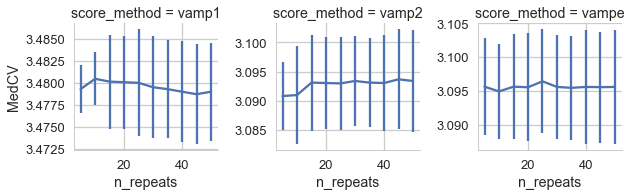

In [36]:
with sns.plotting_context('talk'):
    sns.set_style('whitegrid')
    g = sns.FacetGrid(col='score_method', data=df_split_all, sharey=False)
    g.map(plt.errorbar,'n_repeats', 'MedCV', 'MCV_err')
    plt.savefig('figures/n_repeats_convergence.png', transparent=True)